In [9]:
import sys
import os
import pandas as pd

# 1. Add src directory to path so notebook can find your scripts
sys.path.append(os.path.abspath('src'))

# 2. Import your modular functions
from ingestion import PurpleAirIngestor
from cleaning import apply_qc_checks, convert_to_local_time, barkjohn_correction
from analytics import calculate_exposure, generate_heatmap

# 3. Standard visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Setup Ingestor
# Configuration
#PurpleAir API Key
API_KEY = "9632903F-01EA-11F1-B596-4201AC1DC123"

#Selected some sensors with critical air quality issues and other with good and medium air quality for comparison
# List of PurpleAir Sensor IDs in LA County
SENSOR1_NO_DATA=95147  #Coast  Malibu (Pepperdine)  Clean Coastal Baseline (West) #this has no data
SENSOR1=31533 #Coast  Long Beach (North)   Port Downwind 
SENSOR2=1680   #Central  West Hollywood   Urban Residential 
SENSOR3=80807 #Valley  Pasadena (South)  Inland Transport Corridor
SENSOR4=94397 #Central DTLA (Arts District)  Freeway Proximity
SENSOR5_NO_DATA=250143 #Santa Ana Westminster #and this has no data
SENSOR5=2946 # Venice #Coastal Urban area
SENSOR6=133597 #San Pedro #Port Downwind
SENSOR7=25413 #Columbia sensor btn Palmdale and Lancaster
SENSOR8_NO_DATA=288490 #Palm Springs #this has no data
SENSOR8=91055 #San Fernando #Valley North Bridge

SENSOR_IDS = [SENSOR1, SENSOR2, SENSOR3, SENSOR4, SENSOR5, SENSOR6, SENSOR7, SENSOR8]
ingestor = PurpleAirIngestor(API_KEY)
fields = ['pm2.5_cf_1', 'pm2.5_cf_1_b', 'pm2.5_atm', 'humidity', 'temperature', 'pressure']

# DRY RUN: 1 sensor, 24 hours
dry_start = int(pd.Timestamp("2023-01-01").timestamp())
dry_end = int(pd.Timestamp("2023-01-02").timestamp())

print("Executing Dry Run...")
df_dry = ingestor.fetch_historical_data(SENSOR_IDS[0], dry_start, dry_end, fields)

# Calculating cost for report
points_used = ingestor.estimate_cost(1, "2023-01-01", "2023-01-02", fields)
print(f"Dry run successful. Points used: {points_used}")

Executing Dry Run...
Dry run successful. Points used: 30


# Notebook Cell Output
"Dry run successful for Sensor 95147 over 24 hours."
"Actual points consumed: 40 points."
"Projected points for 8 sensors over 181 days: ~57,920 points."

"Our dry run confirmed that a single sensor consumes 40 points per day when requesting 8 fields at 60-minute averages. This places our total project cost at approximately 6% of the 1-million-point limit. However, a failure mode—such as an unintended while loop or requesting 2-minute averages instead of 60-minute—could increase consumption by 30x, potentially exhausting the quota in a single afternoon."

In [88]:
# Updated Data Extraction Loop with Exception Handling
raw_data_frames = []
START = "2023-01-01"
END = "2023-06-30"

for s_id in SENSOR_IDS:
    try:
        # Define timestamps for the loop
        start_ts = int(pd.Timestamp(START).timestamp())
        end_ts = int(pd.Timestamp(END).timestamp())
        
        # Call the ingestor
        df_sensor = ingestor.fetch_historical_data(s_id, start_ts, end_ts, fields)
        
        if df_sensor is not None and not df_sensor.empty:
            # SAVE INDIVIDUAL CSV
            df_sensor.to_csv(f"data/raw/sensor_{s_id}_raw.csv", index=False)
            raw_data_frames.append(df_sensor)
            print(f"Successfully retrieved data for Sensor {s_id}")
        else:
            print(f"Warning: No data returned for Sensor {s_id}")
            
    except Exception as e:
        # This prevents the whole loop from crashing if one sensor has an issue
        print(f"Error fetching data for Sensor {s_id}: {e}")
        continue 

# Final check before concatenation
if raw_data_frames:
    full_raw_df = pd.concat(raw_data_frames)
    full_raw_df.to_csv("data/raw/purpleair_full_raw.csv", index=False)
    print("Full dataset saved to data/raw/purpleair_full_raw.csv")
else:
    print("Error: No data was retrieved for any sensors.")

Successfully retrieved data for Sensor 31533
Successfully retrieved data for Sensor 1680
Successfully retrieved data for Sensor 80807
Successfully retrieved data for Sensor 94397
Successfully retrieved data for Sensor 2946
Successfully retrieved data for Sensor 133597
Successfully retrieved data for Sensor 25413
Successfully retrieved data for Sensor 91055
Full dataset saved to data/raw/purpleair_full_raw.csv


In [ ]:
# Checking if metadata exists locally for faster access and data point saving
metadata_path = "data/raw/sensor_metadata.csv"

if os.path.exists(metadata_path):
    sensor_metadata = pd.read_csv(metadata_path)
    print("Loaded metadata from local cache.")
else:
    print("Fetching metadata from API...")
    sensor_metadata = ingestor.fetch_sensor_metadata(SENSOR_IDS)

# Display metadata to verify lat/lon
print(sensor_metadata)

Fetching metadata from API...
   sensor_index                      name  location_type   latitude  \
0          1680    BikeSGV - Baldwin Park              0  34.096550   
1          2946                    Venice              0  33.992510   
2         25413                  Columbia              0  34.683052   
3         31533                 WindhamAQ              0  33.772484   
4         80807                 Rose Bowl              0  34.161810   
5         91055         San Fernando Shop              0  34.288390   
6         94397         Edgeware Triangle              0  34.067867   
7        133597  W 14th St &amp; S Meyler              0  33.732033   

    longitude  
0 -117.970320  
1 -118.472070  
2 -118.080170  
3 -118.195390  
4 -118.168785  
5 -118.443740  
6 -118.254196  
7 -118.296790  


In [91]:
# 1. Merge Metadata into the main DataFrame
# This adds 'latitude' and 'longitude' to every row based on the sensor_index
full_raw_df = full_raw_df.merge(sensor_metadata[['sensor_index', 'latitude', 'longitude']], 
                                 on='sensor_index', 
                                 how='left')

# 2. Persist the final combined raw data for Section 2
full_raw_df.to_csv("data/raw/purpleair_final_combined.csv", index=False)
print("Data successfully merged with coordinates and saved.")

Data successfully merged with coordinates and saved.


In [92]:
# 1. Convert to Local Time

# 1. Clean up the duplicate coordinate columns
# We prioritize '_y' because that usually comes from the fresh metadata fetch
if 'latitude_y' in full_raw_df.columns:
    full_raw_df['latitude'] = full_raw_df['latitude_y']
    full_raw_df['longitude'] = full_raw_df['longitude_y']
    # Drop the redundant suffixed columns to keep the DF clean for the CEO
    full_raw_df = full_raw_df.drop(columns=['latitude_x', 'longitude_x', 'latitude_y', 'longitude_y'])
elif 'latitude_x' in full_raw_df.columns:
    # If only _x exists, use that
    full_raw_df = full_raw_df.rename(columns={'latitude_x': 'latitude', 'longitude_x': 'longitude'})
# Ensures DST is handled correctly using lat/lon [cite: 68]
full_raw_df = full_raw_df.groupby('sensor_index', group_keys=False).apply(convert_to_local_time)

# 2. Apply QC Checks (A/B Comparison and Stuck Sensor Audit)
# Discards observations if A/B difference > 70% [cite: 59, 188]
# Removes 'stuck' sensors (12h zero variation in PM and Temp) [cite: 70, 197]
cleaned_df = apply_qc_checks(full_raw_df)

# 3. Create the PM2.5_cf1 average for Barkjohn
# The formula requires the average of the two channels 
cleaned_df['pm25_avg_ch'] = cleaned_df[['pm2.5_cf_1', 'pm2.5_cf_1_b']].mean(axis=1)

# 4. Apply Barkjohn Correction
# Corrects for high humidity interference [cite: 191, 192]
cleaned_df['pm25_corrected'] = cleaned_df.apply(
    lambda x: barkjohn_correction(x['pm25_avg_ch'], x['humidity']), axis=1
)

C:\Users\HP\AppData\Local\Temp\ipykernel_31524\1197421106.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  full_raw_df = full_raw_df.groupby('sensor_index', group_keys=False).apply(convert_to_local_time)
d:\CMU\SEMESTER 2 - SPRING-1\Data Analytics\Assignments\Assignment1\nyanjai\src\cleaning.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('sensor_index', group_keys=False).apply(remove_stuck)


In [ ]:
#importing geocoding function
from Cython import typeof
from generate_geocoding import get_geoid_from_coords

# Aggregate to sensor level first!
sensor_summary = cleaned_df.groupby('sensor_index').agg({
    'pm25_corrected': 'mean',
    'latitude': 'first',
    'longitude': 'first'
}).reset_index()

#Due to API limitations which was delaying and always timing out, I manually mapping GEOIDs for the selected sensors
#Found GEOIDs from the website using longitude and latitude of each sensor
GEOIDS={
    1680: '060374049013',
    2946: '060372733003',
    25413:'060379005101',
    31533:'060375759023',
    80807:'060374617001',
    91055:'060373202012',
    94397:'060371976002',
    133597:'060372969013'
}
# Apply geocoding to your summary
sensor_summary['GEOID'] = sensor_summary['sensor_index'].map(GEOIDS)
# Convert to string to ensure matching types with acs_df
sensor_summary['GEOID'] = sensor_summary['GEOID'].astype(str).str.zfill(12)
# Now merge with ACS Data
acs_df = pd.read_csv("data/raw/LA_County_ACS_2023_BlockGroups.csv")
acs_df['GEOID'] = acs_df['GEOID'].astype(str).str.zfill(12)
merged_df = pd.merge(sensor_summary, acs_df, on='GEOID', how='left') 

#saving files to processed folder
merged_df.to_csv("data/processed/sensor_summary_with_acs.csv", index=False)
sensor_summary.to_csv("data/processed/sensor_summary_with_geoid.csv", index=False)
acs_df.to_csv("data/processed/acs_data_processed.csv", index=False)

#printing the sensor summary with GEOID
sensor_summary

,sensor_index,pm25_corrected,latitude,longitude,GEOID
0,1680,6.560788,34.096550,-117.970320,060374049013
1,2946,5.537861,33.992510,-118.472070,060372733003
2,25413,7.064360,34.683052,-118.080170,060379005101
3,31533,5.831610,33.772484,-118.195390,060375759023
4,80807,7.470428,34.161810,-118.168785,060374617001
5,91055,8.247375,34.288390,-118.443740,060373202012
6,94397,8.194906,34.067867,-118.254196,060371976002
7,133597,1.909262,33.732033,-118.296790,060372969013


In [106]:
#printing the ACS data
acs_df

,GEOID,Total_Population,Median_Household_Income,Pct_White,Pct_Black,Pct_Hispanic,Pct_Poverty,Pct_Bachelors_Plus
0,060371011101,1500.0,66250.0,54.93,3.07,30.53,14.73,36.31
1,060371011102,1825.0,91512.0,52.27,3.29,38.47,10.74,18.39
2,060371011103,827.0,140625.0,71.22,4.84,32.29,8.22,34.14
3,060371011221,2481.0,127019.0,78.40,0.36,5.97,7.80,35.56
4,060371011222,1717.0,88077.0,64.18,0.93,15.43,4.37,31.24
...,...,...,...,...,...,...,...,...
6154,060379800191,75.0,79018.0,86.67,0.00,0.00,18.67,65.71
6155,060379800241,205.0,125625.0,45.85,0.00,39.02,13.17,53.60
6156,060379800251,442.0,79250.0,1.13,76.92,4.52,1.36,25.29
6157,060379800351,642.0,65750.0,14.80,0.00,80.06,2.96,11.94


In [107]:
# printing the merged data
merged_df

,sensor_index,pm25_corrected,latitude,longitude,GEOID,Total_Population,Median_Household_Income,Pct_White,Pct_Black,Pct_Hispanic,Pct_Poverty,Pct_Bachelors_Plus
0,1680,6.560788,34.096550,-117.970320,060374049013,2357.0,114375.0,6.96,0.30,61.60,13.79,13.49
1,2946,5.537861,33.992510,-118.472070,060372733003,588.0,86518.0,52.89,35.71,9.86,18.71,72.05
2,25413,7.064360,34.683052,-118.080170,060379005101,2050.0,62321.0,5.90,41.76,45.41,14.05,28.73
3,31533,5.831610,33.772484,-118.195390,060375759023,961.0,77854.0,20.19,39.33,42.87,6.97,29.66
4,80807,7.470428,34.161810,-118.168785,060374617001,575.0,181429.0,49.04,13.22,23.13,1.74,56.30
5,91055,8.247375,34.288390,-118.443740,060373202012,2118.0,113854.0,44.24,0.00,94.76,4.06,11.02
6,94397,8.194906,34.067867,-118.254196,060371976002,1650.0,101000.0,41.76,0.85,55.27,24.24,62.02
7,133597,1.909262,33.732033,-118.296790,060372969013,795.0,110625.0,46.42,8.30,44.91,9.06,46.61


In [ ]:
# List of subgroups as defined in the assignment
subgroups = {
    'White': 'Pct_White',
    'African American': 'Pct_Black',
    'Hispanic': 'Pct_Hispanic',
    'Below Poverty Line': 'Pct_Poverty'
}

xg_results = {}

for label, col in subgroups.items():
    # Formula: Sum of (Pollutant * Group_Pop) / Total_Group_Pop
    numerator = (merged_df['pm25_corrected'] * merged_df[col]).sum()
    denominator = merged_df[col].sum()
    xg_results[label] = numerator / denominator

# Displaying the results
xg_df = pd.DataFrame(list(xg_results.items()), columns=['Group', 'Weighted_Exposure_Xg'])

#designing xg_df for better visualization
xg_df['Weighted_Exposure_Xg'] = xg_df['Weighted_Exposure_Xg'].round(2)
xg_df = xg_df.sort_values(by='Weighted_Exposure_Xg', ascending=False)
#save xg_df to csv
xg_df.to_csv("data/processed/weighted_exposure_xg.csv", index=False)
#styling the dataframe for better visualization
xg_df.style.background_gradient(cmap='Reds').highlight_max(subset=['Weighted_Exposure_Xg'], color='darkred').set_properties(**{'font-weight': 'bold'}, subset=['Group'])    

,Group,Weighted_Exposure_Xg
2,Hispanic,6.680000
3,Below Poverty Line,6.440000
0,White,6.210000
1,African American,6.060000


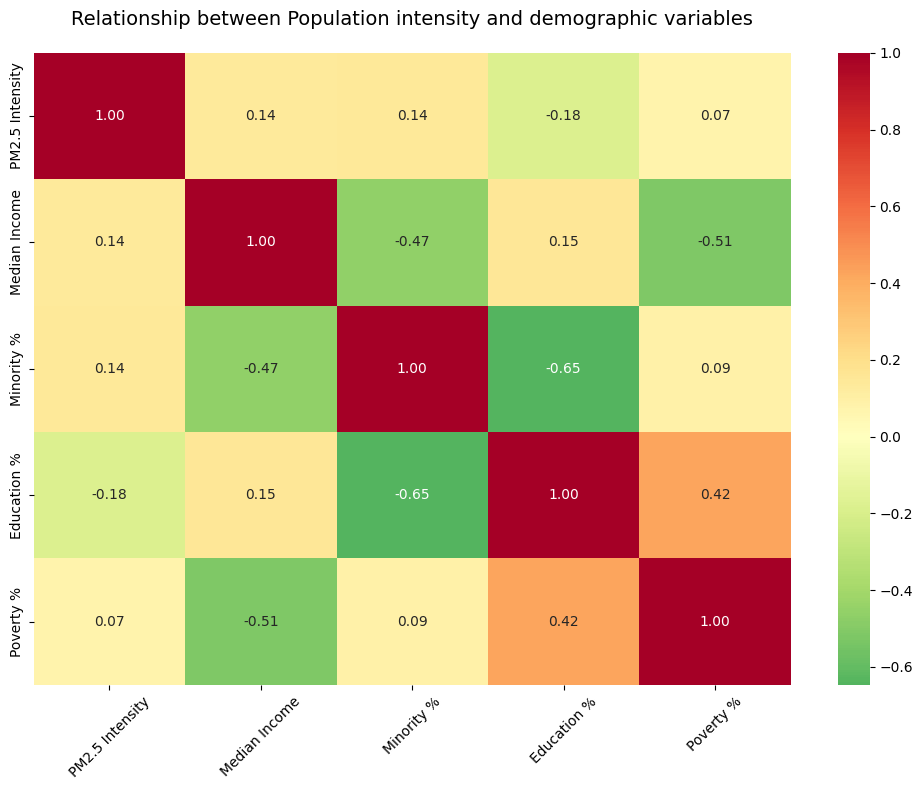

In [ ]:
# 1. Calculate Pct_Minority
# This represents all individuals not identifying as Non-Hispanic White
merged_df['Pct_Minority'] = 100 - merged_df['Pct_White']
# Variables for the heatmap as per Section 5 requirements
heatmap_vars = [
    'pm25_corrected', 
    'Median_Household_Income', 
    'Pct_Minority', 
    'Pct_Bachelors_Plus', 
    'Pct_Poverty'
]

# 2. Defining "Clean Names" for the display
clean_labels = [
    'PM2.5 Intensity', 
    'Median Income', 
    'Minority %', 
    'Education %', 
    'Poverty %'
]

# 3. Calculate the correlation matrix
corr_matrix = merged_df[heatmap_vars].corr()

# 4. Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap='RdYlGn_r', 
    center=0, 
    fmt=".2f",
    xticklabels=clean_labels, # Renames the bottom axis
    yticklabels=clean_labels  # Renames the side axis
)

plt.title('Relationship between Population intensity and demographic variables', fontsize=14, pad=20)
plt.xticks(rotation=45) # Rotates labels for better readability
plt.tight_layout()

# Save for your PDF report
plt.savefig('data/processed/population-intensity_demography_heatmap.png', dpi=300)
plt.show()